# xarray-dask and yt : constructing a test case

In [1]:
from daxryt import data_handling, chunk_inspector
import numpy as np
from dask.distributed import Client
import xarray as xr
import dask 
import os
dask.config.set({"distributed.scheduler.worker-saturation": "inf"})

In [2]:
c = Client(n_workers=os.cpu_count()-2, threads_per_worker=1)
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 31.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39813,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 31.20 GiB
Comm: tcp://127.0.0.1:46371,Total threads: 1
Dashboard: http://127.0.0.1:45141/status,Memory: 7.80 GiB
Nanny: tcp://127.0.0.1:42701,


## building a multi-file on-disk test dataset

The following function will create a multi-file netcdf dataset in the supplied directory. Each `.nc` file will be a continuous spatial subset of the global spatial grid. The dataset will be in cartesian coordinates, you can control the size of the dataset by either varying the number of sub-grids in any dimension (`n_grids_xyz`) or by varying the number of cells in each grid (`cells_per_grid_xyz`): 

In [3]:
rebuild_data = False
if rebuild_data:
    # WARNING THIS BUILDS A 10 Gb dataset
    data_handling.build_test_data(
        n_grids_xyz=(10, 10, 10),
        grid_wids_xyz=np.array([1., 1., 1.]),
        cells_per_grid_xyz=(111, 120, 100),
        output_dir="data",
        clear_output_dir=True, 
        dask_client=c,
    )

when you use `xr_open_mfdataset('directory/*.nc')`, xarray will load the whole directory with dask, with each file corresponding to a dask chunk:

In [4]:
ds_xr = xr.open_mfdataset("data/*.nc")

In [5]:
ds_xr.temperature

,Array,Chunk
Bytes,9.92 GiB,10.16 MiB
Shape,"(1110, 1200, 1000)","(111, 120, 100)"
Count,5000 Tasks,1000 Chunks
Type,float64,numpy.ndarray


The test dataset has a number of fields:

In [6]:
print(ds_xr.data_vars)

Data variables:
    temperature  (x, y, z) float64 dask.array<chunksize=(111, 120, 100), meta=np.ndarray>
    gauss        (x, y, z) float64 dask.array<chunksize=(111, 120, 100), meta=np.ndarray>
    xvals        (x, y, z) float64 dask.array<chunksize=(111, 120, 100), meta=np.ndarray>
    yvals        (x, y, z) float64 dask.array<chunksize=(111, 120, 100), meta=np.ndarray>
    zvals        (x, y, z) float64 dask.array<chunksize=(111, 120, 100), meta=np.ndarray>


The `xvals` , `yvals` , `zvals` arrays are the x,y,z value of each point. These are not needed, as xarray will always store the 1d coordinate arrays in memory, but they are useful in this test case to make sure the grids are being reconstructed properly. 

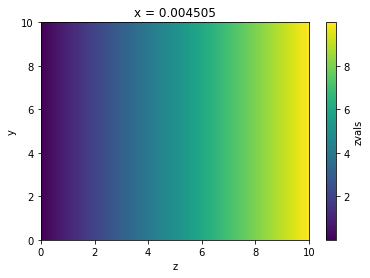

In [7]:
zvals_at_x0 = ds_xr.zvals.isel({"x":0})
zvals_at_x0.plot()

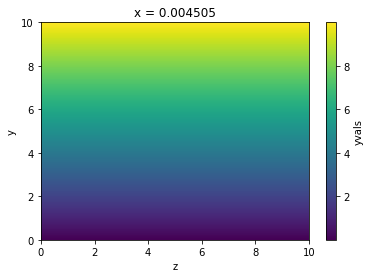

In [8]:
yvals_at_x0 = ds_xr.yvals.isel({"x":0})
yvals_at_x0.plot()

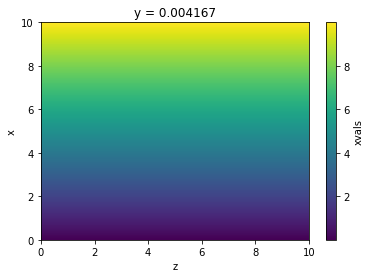

In [9]:
xvals_at_y0 = ds_xr.xvals.isel({"y":0})
xvals_at_y0.plot()

The other two fields are a random variable:

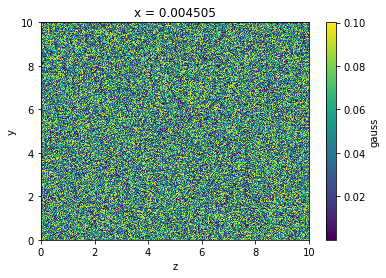

In [10]:
T_at_x = ds_xr.gauss.isel({"x":0})
T_at_x.plot()

and a gaussian field with random noise centered at (x,y,z) = (3,3,3), which again is a nice way to make sure our grids are reconstructing as expected:

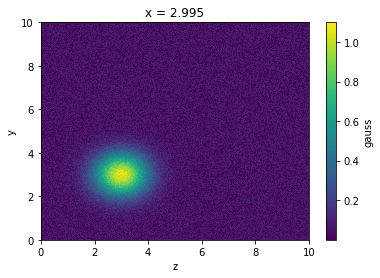

In [11]:
gauss_at_x0 = ds_xr.gauss.sel({"x":3}, method='nearest')
gauss_at_x0.plot()

## chunk inspection 

Based on the figures above, we can be confident `open_mfdataset` is reconstructing our test data sub-grids correctly. 

In linking with yt, we will build a yt dataset with grids covering the global domain. To optimize this, it is helpful to be able to align the dask-xarray chunks with the yt grid objects. 

dask-xarray datasets and variables will have `chunks` and `chunksizes` attributes:

In [12]:
ds_xr.gauss.chunksizes

Frozen({'x': (111, 111, 111, 111, 111, 111, 111, 111, 111, 111), 'y': (120, 120, 120, 120, 120, 120, 120, 120, 120, 120), 'z': (100, 100, 100, 100, 100, 100, 100, 100, 100, 100)})

In [13]:
ds_xr.gauss.chunks

((111, 111, 111, 111, 111, 111, 111, 111, 111, 111),
 (120, 120, 120, 120, 120, 120, 120, 120, 120, 120),
 (100, 100, 100, 100, 100, 100, 100, 100, 100, 100))

but finding the x, y, z limits of each chunk requires some processing. 

The following function steps through the global index, incrementing by the chunksize in each dimension for each chunk. Because the global 1d coordinate arrays are stored in memory, we don't actually need to touch the individual dask chunks in this operations and it only relies on already in-memory attributes of the chunks and the xarray `Dataset`:

In [14]:
chunk_info = chunk_inspector.get_chunk_info(ds_xr)
chunk_info

,si,ei,size,le,re
chunk_number,,,,,
0,"[0, 0, 0]","[111, 120, 100]","[111, 120, 100]","[0.0045045045045045045, 0.004166666666666667, ...","[0.9954954954954954, 0.9958333333333333, 0.994..."
1,"[0, 0, 100]","[111, 120, 200]","[111, 120, 100]","[0.0045045045045045045, 0.004166666666666667, ...","[0.9954954954954954, 0.9958333333333333, 1.994..."
2,"[0, 0, 200]","[111, 120, 300]","[111, 120, 100]","[0.0045045045045045045, 0.004166666666666667, ...","[0.9954954954954954, 0.9958333333333333, 2.995]"
3,"[0, 0, 300]","[111, 120, 400]","[111, 120, 100]","[0.0045045045045045045, 0.004166666666666667, ...","[0.9954954954954954, 0.9958333333333333, 3.995]"
4,"[0, 0, 400]","[111, 120, 500]","[111, 120, 100]","[0.0045045045045045045, 0.004166666666666667, ...","[0.9954954954954954, 0.9958333333333333, 4.995]"
...,...,...,...,...,...
995,"[999, 1080, 500]","[1110, 1200, 600]","[111, 120, 100]","[9.004504504504505, 9.004166666666666, 5.005]","[9.995495495495495, 9.995833333333334, 5.995]"
996,"[999, 1080, 600]","[1110, 1200, 700]","[111, 120, 100]","[9.004504504504505, 9.004166666666666, 6.005]","[9.995495495495495, 9.995833333333334, 6.995]"
997,"[999, 1080, 700]","[1110, 1200, 800]","[111, 120, 100]","[9.004504504504505, 9.004166666666666, 7.005]","[9.995495495495495, 9.995833333333334, 7.99499..."


it works for full xarray `Dataset` objects (as above) and also for xarray `DataArray` objects:

In [15]:
chunk_info = chunk_inspector.get_chunk_info(ds_xr.temperature)
chunk_info

,si,ei,size,le,re
chunk_number,,,,,
0,"[0, 0, 0]","[111, 120, 100]","[111, 120, 100]","[0.0045045045045045045, 0.004166666666666667, ...","[0.9954954954954954, 0.9958333333333333, 0.994..."
1,"[0, 0, 100]","[111, 120, 200]","[111, 120, 100]","[0.0045045045045045045, 0.004166666666666667, ...","[0.9954954954954954, 0.9958333333333333, 1.994..."
2,"[0, 0, 200]","[111, 120, 300]","[111, 120, 100]","[0.0045045045045045045, 0.004166666666666667, ...","[0.9954954954954954, 0.9958333333333333, 2.995]"
3,"[0, 0, 300]","[111, 120, 400]","[111, 120, 100]","[0.0045045045045045045, 0.004166666666666667, ...","[0.9954954954954954, 0.9958333333333333, 3.995]"
4,"[0, 0, 400]","[111, 120, 500]","[111, 120, 100]","[0.0045045045045045045, 0.004166666666666667, ...","[0.9954954954954954, 0.9958333333333333, 4.995]"
...,...,...,...,...,...
995,"[999, 1080, 500]","[1110, 1200, 600]","[111, 120, 100]","[9.004504504504505, 9.004166666666666, 5.005]","[9.995495495495495, 9.995833333333334, 5.995]"
996,"[999, 1080, 600]","[1110, 1200, 700]","[111, 120, 100]","[9.004504504504505, 9.004166666666666, 6.005]","[9.995495495495495, 9.995833333333334, 6.995]"
997,"[999, 1080, 700]","[1110, 1200, 800]","[111, 120, 100]","[9.004504504504505, 9.004166666666666, 7.005]","[9.995495495495495, 9.995833333333334, 7.99499..."


The columns here are:

* si, ei : the global start and end index of the chunk
* size : the size of the chunk
* le, re : the left and right edge of the chunk in the global x,y,z coordinates

## loading in yt 

We're now ready to load into yt. 

### without grid-alignment



In [16]:
import yt
from yt.utilities.decompose import decompose_array, get_psize

In [17]:
def _read_data(handle):
    def _reader(grid, field_name):
        ftype, fname = field_name
        si = grid.get_global_startindex()
        ei = si + grid.ActiveDimensions
        var = getattr(handle, fname)  # variables are top-level attrs of xr datasets        
        data = var[si[0] : ei[0], si[1] : ei[1], si[2] : ei[2]]
        return data.values

    return _reader


reader = _read_data(ds_xr)

fields = list(ds_xr.data_vars)
global_shape = ds_xr.data_vars[fields[0]].shape
global_left = np.array([ds_xr.coords[cn].min() for cn in ds_xr.dims.keys()])
global_right = np.array([ds_xr.coords[cn].max() for cn in ds_xr.dims.keys()])
bbox = np.column_stack([global_left, global_right])


# decompose the grid for yt, ignoring the xarray chunking
n_grid_chunks = 1000  # (nprocs in load_uniform_grid)
psize = get_psize(np.array(global_shape), n_grid_chunks)
grid_left_edges, grid_right_edges, grid_shapes, slices = decompose_array(
    global_shape, psize, bbox
)


grid_data = []
for gid in range(n_grid_chunks):
    new_grid = {
        "left_edge": grid_left_edges[gid],
        "right_edge": grid_right_edges[gid],            
        "dimensions": grid_shapes[gid],
        "level": 0,
    }
    for field in fields:
        new_grid[field] = reader
        
    grid_data.append(new_grid)
    

ds = yt.load_amr_grids(grid_data, global_shape, bbox=bbox)


yt : [INFO     ] 2022-12-08 15:37:49,374 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-12-08 15:37:49,375 Parameters: domain_dimensions         = [1110 1200 1000]
yt : [INFO     ] 2022-12-08 15:37:49,376 Parameters: domain_left_edge          = [0.0045045  0.00416667 0.005     ]
yt : [INFO     ] 2022-12-08 15:37:49,377 Parameters: domain_right_edge         = [9.9954955  9.99583333 9.995     ]
yt : [INFO     ] 2022-12-08 15:37:49,378 Parameters: cosmological_simulation   = 0


In [18]:
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 31.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39813,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 31.20 GiB
Comm: tcp://127.0.0.1:46371,Total threads: 1
Dashboard: http://127.0.0.1:45141/status,Memory: 7.80 GiB
Nanny: tcp://127.0.0.1:42701,


yt : [INFO     ] 2022-12-08 15:37:56,229 xlim = 0.004167 9.995833
yt : [INFO     ] 2022-12-08 15:37:56,229 ylim = 0.005000 9.995000
yt : [INFO     ] 2022-12-08 15:37:56,230 xlim = 0.004167 9.995833
yt : [INFO     ] 2022-12-08 15:37:56,231 ylim = 0.005000 9.995000
yt : [INFO     ] 2022-12-08 15:37:56,234 Making a fixed resolution buffer of (('stream', 'gauss')) 800 by 800



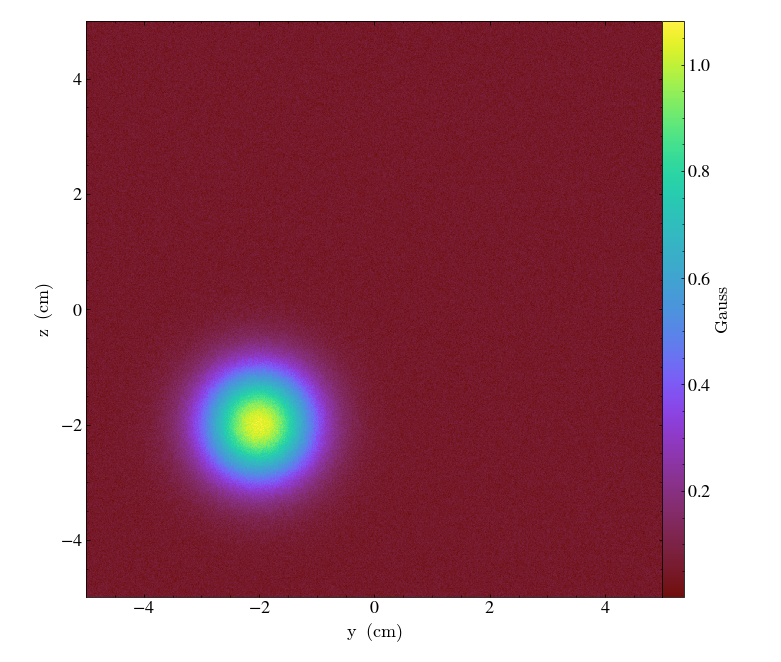

In [19]:
fld = ('stream', "gauss")
ce = ds.domain_center
ce[0] = 3.
slc = yt.SlicePlot(ds, "x", fld, center = ce)
slc.set_log(fld, False)

In [20]:
# projection plot is killing..
# fld = ('stream', "gauss")
# prj = yt.ProjectionPlot(ds, "x", fld, weight_field=None)
# prj.set_log(fld, False)
# prj.show()

In [21]:
sp = ds.sphere(ds.arr([3.,3.,3.],'code_length'), 2.)
sp.center

unyt_array([3., 3., 3.], 'code_length')

yt : [INFO     ] 2022-12-08 15:38:08,394 xlim = -1.995833 7.995833
yt : [INFO     ] 2022-12-08 15:38:08,395 ylim = -1.995000 7.995000
yt : [INFO     ] 2022-12-08 15:38:08,395 xlim = -1.995833 7.995833
yt : [INFO     ] 2022-12-08 15:38:08,396 ylim = -1.995000 7.995000
yt : [INFO     ] 2022-12-08 15:38:08,398 Making a fixed resolution buffer of (('stream', 'gauss')) 800 by 800



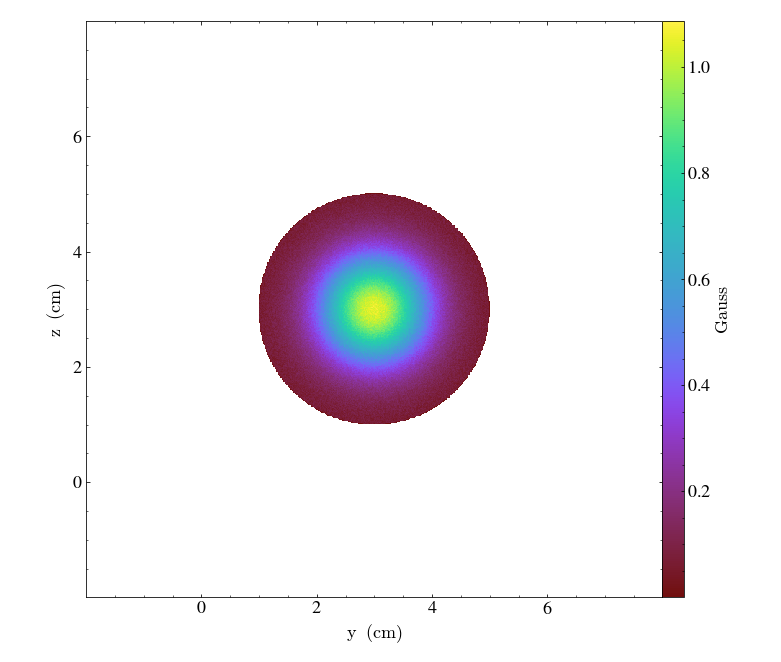

In [22]:
fld = ('stream', "gauss")
slc = yt.SlicePlot(ds, "x", fld, center = sp.center, data_source=sp, origin='native')
slc.set_log(fld, False)

In [23]:
sp.quantities.max_location(fld)

[unyt_quantity(1.09894322, '(dimensionless)'),
 unyt_quantity(2.99730136, 'code_length'),
 unyt_quantity(3.00582986, 'code_length'),
 unyt_quantity(3.026975, 'code_length')]

In [24]:
sp.quantities.total_quantity(fld)

unyt_quantity(9316086.05775456, '(dimensionless)')


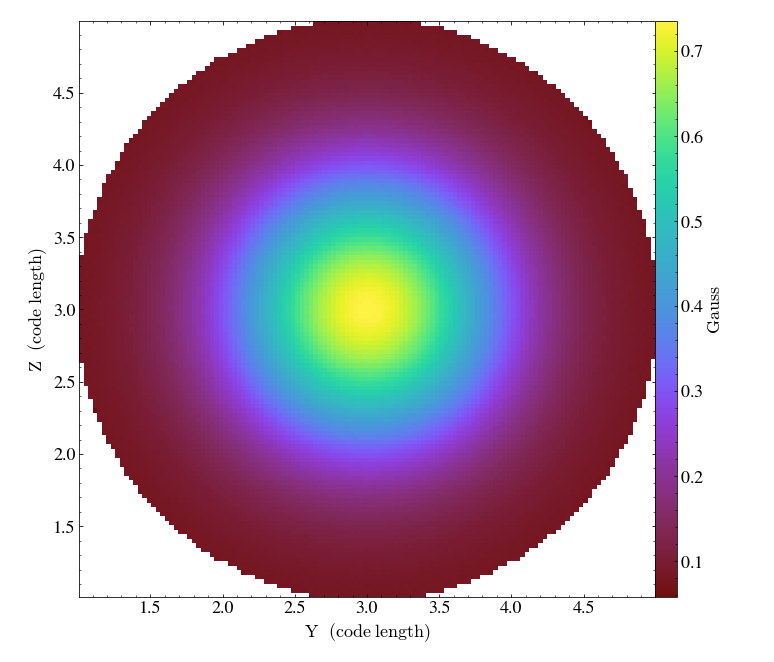

In [25]:
pp = yt.PhasePlot(sp, ("index", "y"), ("index", "z"), fld, weight_field=fld)
pp.set_log(fld, False)


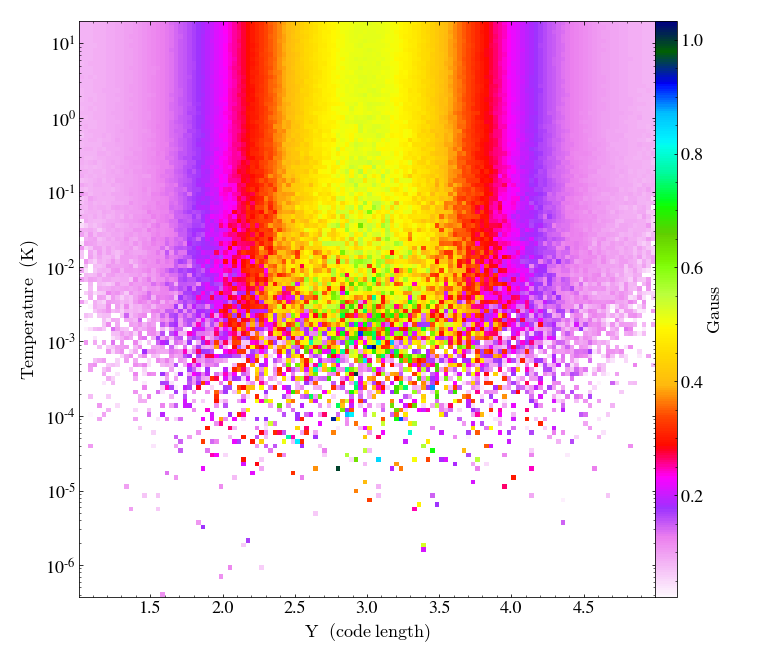

In [26]:
pp = yt.PhasePlot(sp, ("index", "y"), ("stream", "temperature"), fld, weight_field=fld)
pp.set_cmap(fld, "gist_ncar_r")
pp.set_log(fld, False)

## aligning the xarray and yt grids



## Some test cases 

### 3d selection objects

### quantities

### plots